# Electricity Demand Forecasting

This notebook performs demand forecasting for Kansai Electric Power (JP) using linear regression and support vector regression. It includes data loading, feature engineering, model development, evaluation, error analysis, improvement hypotheses, and expected deployment benefits.

## 1. Data Loading
Assumes you have two CSV files in the working directory:

- `demand_data.csv` containing columns `timestamp` and `demand`.
- `weather_data.csv` containing weather features with a `timestamp` column.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('dataset.csv',parse_dates=['datetime'])
data = data.set_index('datetime')
data.index = pd.to_datetime(data.index)

# Filter up to end of 2022 for training
train = data.loc[:'2022-12-31 23:00:00'].copy()
test= data.loc['2022-12-31 23:00:00':].copy()
data.shape

(183959, 13)

## 2. Feature Engineering
- Create datetime features
- Lag features for demand
- Rolling mean features

In [13]:

train['hour'] = train.index.hour
train['dayofweek'] = train.index.dayofweek
train['month'] = train.index.month

for lag in [1,24,168]:
    train[f'demand_lag_{lag}'] = train['actual_performance(10000 kW)'].shift(lag)

train['rolling_24h'] = train['actual_performance(10000 kW)'].rolling(24).mean()
train = train.dropna()


## 3. Model Development
We will develop two models:
1. **Multi Variate Linear Regression**
2. **Support Vector Regression (SVR)**

### 3.1 Prepare Training Data

In [14]:
from sklearn.model_selection import train_test_split

# Features and target
features = [col for col in train.columns if col != 'actual_performance(10000 kW)']
X = train[features]
y = train['actual_performance(10000 kW)']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    shuffle=False)

print(X_train.shape)
X_train.head(5)

(97976, 16)


,precipitation,temperature,dew_point_temperature,humidity,wind_speed,wind_direction,snowfall,location,hour,dayofweek,month,lag_1,demand_lag_1,demand_lag_24,demand_lag_168,rolling_24h
datetime,,,,,,,,,,,,,,,,
2021-01-02,0.0,2.6,-4.8,58.0,4.8,West-Northwest,0.0,Weather\kobe,0,5,1,1438.0,1438.0,1663.0,1571.0,1568.708333
2021-01-02,0.0,1.5,-3.9,67.0,2.0,West,0.0,Weather\kyoto,0,5,1,1438.0,1438.0,1663.0,1571.0,1559.333333
2021-01-02,0.0,3.4,-4.5,56.0,1.1,West-Southwest,0.0,Weather\osaka,0,5,1,1438.0,1438.0,1640.0,1571.0,1550.916667
2021-01-02,0.0,4.9,-3.4,55.0,2.4,North-Northwest,0.0,Weather\shionomisaki,0,5,1,1438.0,1438.0,1640.0,1571.0,1542.500000
2021-01-02,0.0,-0.3,-0.4,99.0,0.4,South-Southwest,0.0,Weather\toyooka,0,5,1,1438.0,1438.0,1640.0,1571.0,1534.083333


### 3.2 Multi Variate Linear Regression Model

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object','category']).columns.tolist()

# 2) Build the preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(),          numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'),
                                      categorical_features),
])

# 3) Combine into a full pipeline
lr_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('lr',      LinearRegression())
])

# 4) Fit & score
lr_pipeline.fit(X_train, y_train)
print(f"Train R²: {lr_pipeline.score(X_train, y_train): .4f}")
print(f"Test  R²:  {lr_pipeline.score(X_test,  y_test): .4f}")


Train R²:  0.9922
Test  R²:   0.9923


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

# 1) Identify feature types
numeric_features     = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object','category']).columns.tolist()

# 2) Build the preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(),       numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features),
])

# 3) Create a pipeline with a placeholder estimator
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model',   LinearRegression())
])

# 4) Define the hyperparameter grid
param_grid = [
    # Variant 1: plain LinearRegression
    {
        'model': [LinearRegression()],
        'model__fit_intercept': [True, False],
    },
    # Variant 2: Ridge regression
    {
        'model': [Ridge()],
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'model__fit_intercept': [True, False],
    }
]

# 5) Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 6) Fit on training data
grid_search.fit(X_train, y_train)

# 7) Review best parameters and performance
print("Best hyperparameters:", grid_search.best_params_)
print(f"Best CV R²: {grid_search.best_score_:.4f}")

# 8) Evaluate on test set
best_model = grid_search.best_estimator_
print(f"Test R²: {best_model.score(X_test, y_test):.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'model': Ridge(), 'model__alpha': 0.01, 'model__fit_intercept': True}
Best CV R²: 0.9916
Test R²: 0.9923


### 3.3 Support Vector Regression Model

In [17]:
from sklearn.compose       import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline      import Pipeline
from sklearn.svm           import SVR

# 1) Identify your columns
num_feats = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_feats = X_train.select_dtypes(include=['object','category']).columns.tolist()

# 2) Build a preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(),      num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
], remainder='drop')

# 3) Full pipeline: preprocessor → SVR
svr_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('svr',     SVR(kernel='rbf', C=1.0, epsilon=0.1))
])

# 4) Fit & evaluate
"""
svr_pipeline.fit(X_train, y_train)
print("Train R²:", svr_pipeline.score(X_train, y_train))
print("Test  R²:",  svr_pipeline.score(X_test,  y_test))

"""
X_train1=X_train[:70000]
X_test1=X_test[:30000]
y_train1=y_train[:70000]
y_test1=y_test[:30000]

svr_pipeline.fit(X_train1, y_train1)

#coefficient of determination, commonly called R²

print(f"Train R²: {svr_pipeline.score(X_train1, y_train1): .4f}")
print(f"Test  R²: { svr_pipeline.score(X_test1,  y_test1): .4f}")

Train R²:  0.9702
Test  R²:  0.9734


### 3.4 Gradient Boosting Machine (XGBoost) Model

In [21]:
from xgboost import XGBRegressor
from sklearn.compose       import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline      import Pipeline
import matplotlib.pyplot as plt

num_feats = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_feats = X_train.select_dtypes(include=['object','category']).columns.tolist()

# Building the preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(),      num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
], remainder='drop')

# Full pipeline: preprocessor → XGBoost regressor
xgb_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('xgb', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=1
    ))
])

# 6) Fit to training data
xgb_pipeline.fit(X_train, y_train)

# 7) Evaluate
print(f"Train  R²: {xgb_pipeline.score(X_train, y_train):.4f}")
print(f"Test   R²: {xgb_pipeline.score(X_test,  y_test): .4f}")


Train  R²: 0.9943
Test   R²:  0.9945


## 4. Evaluation
We use MAE, RMSE, and MAPE to assess performance.

In [23]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

models = {'Linear Regression': lr_pipeline, 'SVR': svr_pipeline , 'XGBoost':xgb_pipeline}

for name, model in models.items():
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mape_val = mape(y_test, preds)
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape_val:.2f}%")


Linear Regression: MAE=13.25, RMSE=28.38, MAPE=0.82%
SVR: MAE=23.25, RMSE=52.86, MAPE=1.37%
XGBoost: MAE=11.83, RMSE=24.04, MAPE=0.74%


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

models = {'Linear Regression': best_model, 'SVR': best_svr , 'XGBoost':best_xgb}

for name, model in models.items():
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mape_val = mape(y_test, preds)
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape_val:.2f}%")


## 5. Plot Actual vs Predicted

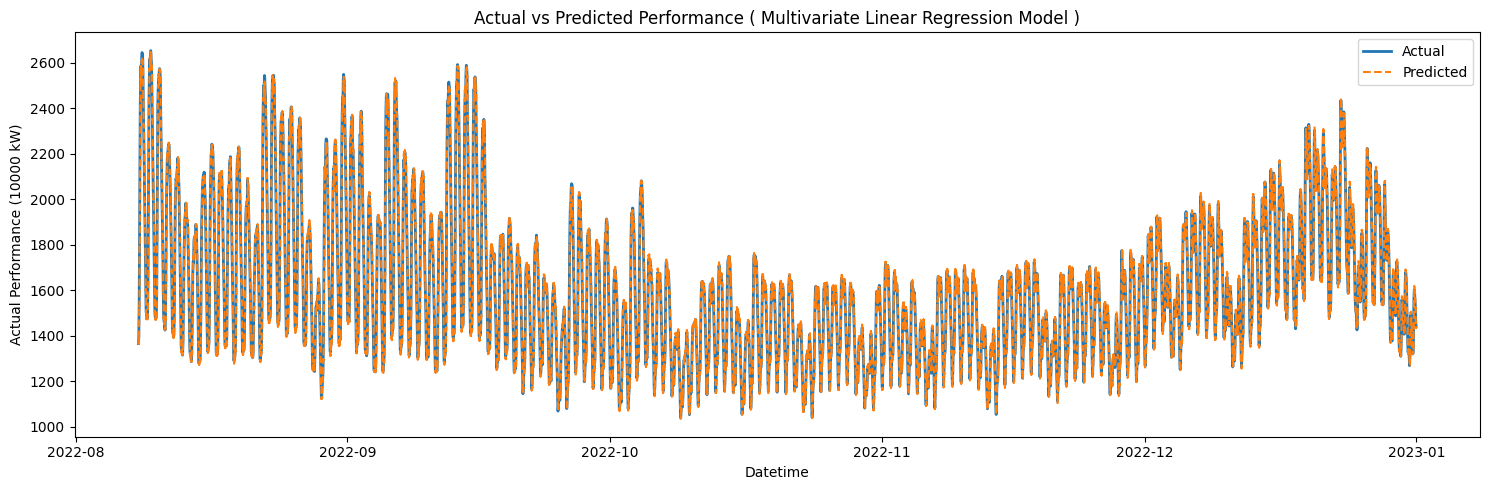

In [24]:
#Generate predictions on the test set using Linear Regression model
y_pred = lr_pipeline.predict(X_test)

# Plot actual vs. predicted time series
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
plt.xlabel('Datetime')
plt.ylabel('Actual Performance (10000 kW)')
plt.title('Actual vs Predicted Performance ( Multivariate Linear Regression Model )')
plt.legend()
plt.tight_layout()
plt.show()

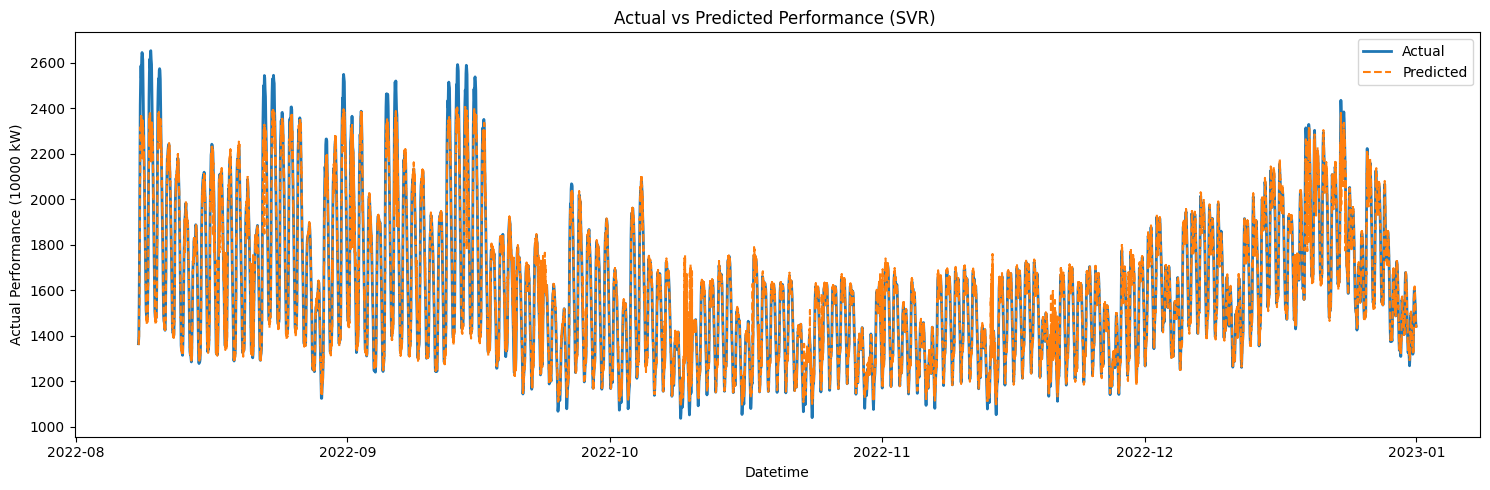

In [25]:
#Generate predictions on the test set using SVR
y_pred = svr_pipeline.predict(X_test)

# Plot actual vs. predicted time series
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
plt.xlabel('Datetime')
plt.ylabel('Actual Performance (10000 kW)')
plt.title('Actual vs Predicted Performance (SVR) ')
plt.legend()
plt.tight_layout()
plt.show()


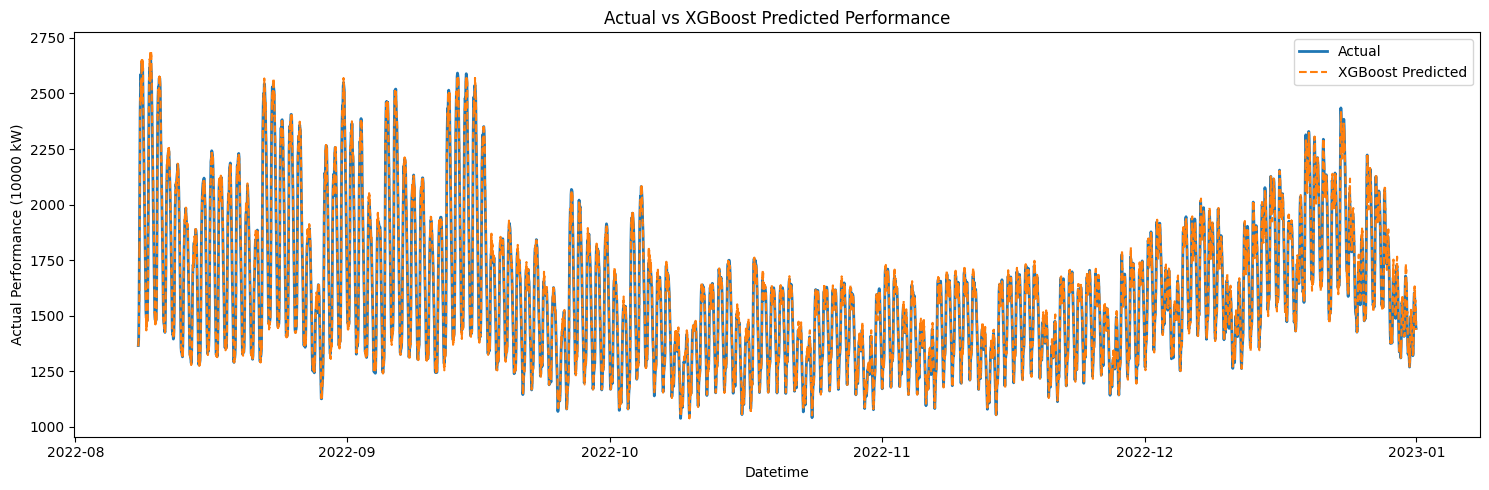

In [26]:
# Generate predictions & plot using XGBoosst
y_pred = xgb_pipeline.predict(X_test)

plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred, label='XGBoost Predicted', linestyle='--')
plt.xlabel('Datetime')
plt.ylabel('Actual Performance (10000 kW)')
plt.title('Actual vs XGBoost Predicted Performance')
plt.legend()
plt.tight_layout()
plt.show()

## 6. Hypotheses for Accuracy Improvement
- Use advanced time-series models (ARIMA, Prophet, LSTM)
- Add holiday and special event indicators

## 7. Expected Benefits of Model Deployment
- Improved operational planning and resource allocation
- Cost savings through better demand-response management
- Enhanced reliability of power supply and reduced outages